In [1]:
import codecs
import datetime
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
sns.set_context("talk")
sns.set_style("white")
print("Loaded Libraries...")

Loaded Libraries...


## To Do 

- Split effect by gender

In [2]:
def analyze_effect_results(results_df, effect, word, alt, savefig=None):
    
    # calculate odds
    if alt == "man":
        odds_base = results_df['candidate1_base_prob'] / results_df['candidate2_base_prob']
        odds_intervention = results_df['candidate1_prob'] / results_df['candidate2_prob']
    else:
        odds_base = results_df['candidate2_base_prob'] / results_df['candidate1_base_prob']
        odds_intervention = results_df['candidate2_prob'] / results_df['candidate1_prob']
    odds_ratio = odds_intervention / odds_base
    results_df['odds_ratio'] = odds_ratio
    
    if word == 'all':
        # average over words
        results_df = results_df.groupby(['layer', 'neuron'], as_index=False).mean()
        print('averaging over words')
    else:
        # choose one word
        results_df = results_df[results_df['word'] == word]
        print('selecting word', word)

    results_df = results_df.pivot('neuron', 'layer', 'odds_ratio')

    print('Effect:', effect.upper())
    if effect=='indirect':
        print("Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron")
    elif effect == 'direct':
        print("Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron")
    else:
        raise ValueError(f"Invalid effect: {effect}")

    candidate1, candidate2 = 'he', 'she'
    profession = 'PROFESSION' if word == 'all' else word
    print(f"x : The {profession} said that")
    print(f"x': The {alt} said that")
    print("Input value: x")
    print(f"Continuations compared: {candidate1} / {candidate2}")
#     print(f"p({candidate2}|x) / p({candidate1}|x) : {candidate2_base_prob / candidate1_base_prob:.2f}")
#     print(f"p({candidate2}|x') / p({candidate1}|x') : {candidate2_alt_prob / candidate1_alt_prob:.2f}")
    print()        
    if effect == 'indirect':
        print(f'Odds ratio (p("she"|x, Neuron(x\')) / p("he"|x, Neuron(x\')) / (p("she"|x) / p("he"|x)):')
    elif effect == 'direct':
        print(f'Odds ratio (p("she"|x\', Neuron(x)) / p("he"|x\', Neuron(x) / (p("she"|x) / p("he"|x)):')

    plt.figure(figsize=(6,30)) 
    sns.heatmap(results_df) #, annot=True, annot_kws={"size": 12}, fmt=".2f")
    if savefig:
        plt.savefig(savefig)


In [3]:
folder_name = "results/20191003_neuron_intervention/"
fnames = [f[:-4] for f in os.listdir(folder_name) if f.endswith("csv")]
paths = [os.path.join(folder_name, f) for f in os.listdir(folder_name) if f.endswith("csv")]
modes = ['direct', 'indirect', 'indirect','indirect','indirect','direct']
fnames, paths

(['woman_direct',
  'woman_indirect',
  'man_indirect',
  'woman_minus_man',
  'man_minus_woman',
  'man_direct'],
 ['results/20191003_neuron_intervention/woman_direct.csv',
  'results/20191003_neuron_intervention/woman_indirect.csv',
  'results/20191003_neuron_intervention/man_indirect.csv',
  'results/20191003_neuron_intervention/woman_minus_man.csv',
  'results/20191003_neuron_intervention/man_minus_woman.csv',
  'results/20191003_neuron_intervention/man_direct.csv'])

## Generate Plots

averaging over words
Effect: DIRECT
Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron
x : The PROFESSION said that
x': The woman said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x', Neuron(x)) / p("he"|x', Neuron(x) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron
x : The PROFESSION said that
x': The woman said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x, Neuron(x')) / p("he"|x, Neuron(x')) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron
x : The PROFESSION said that
x': The woman said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x, Neuron(x')) / p("he"|x, Neuron(x')) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x') 

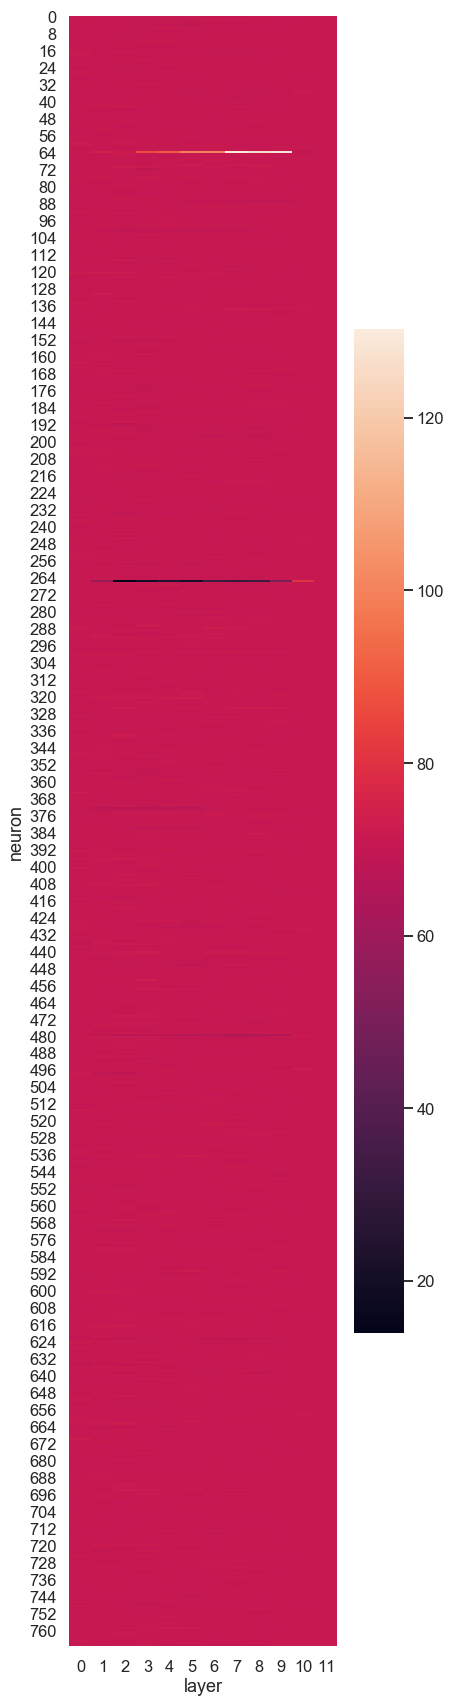

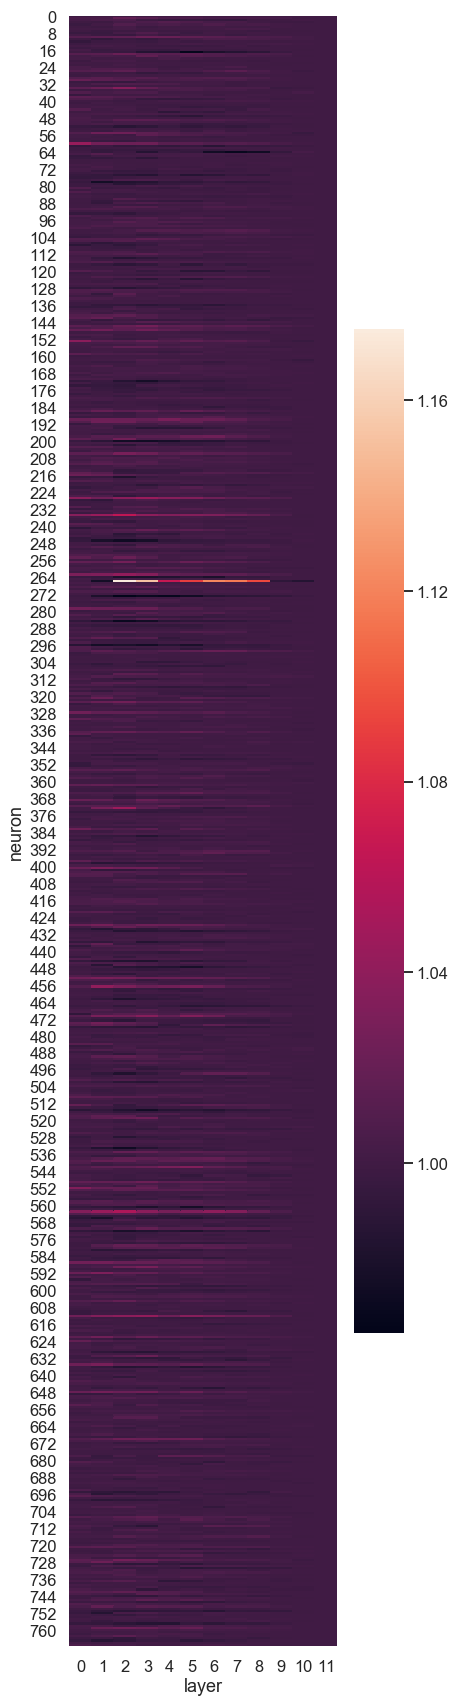

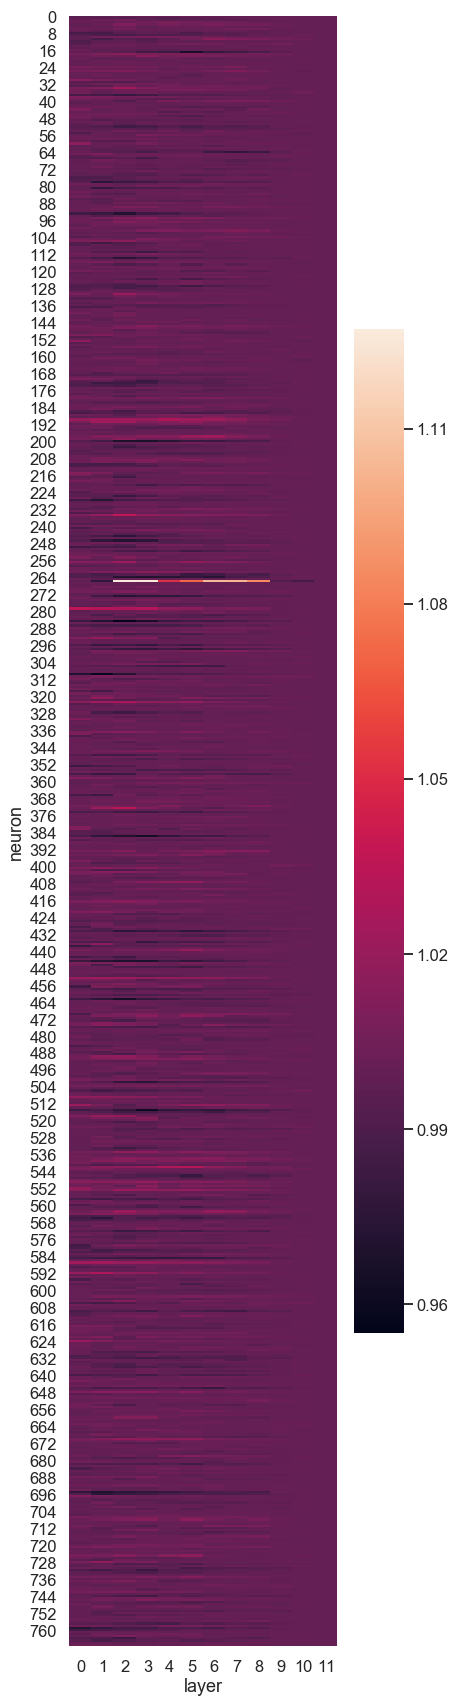

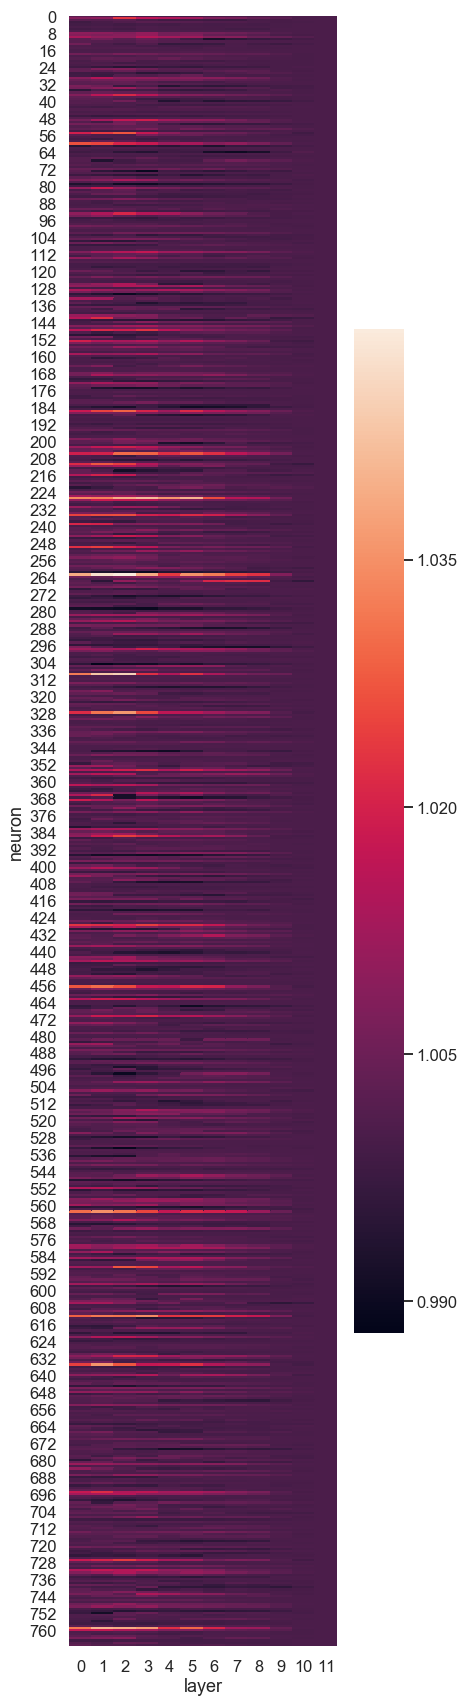

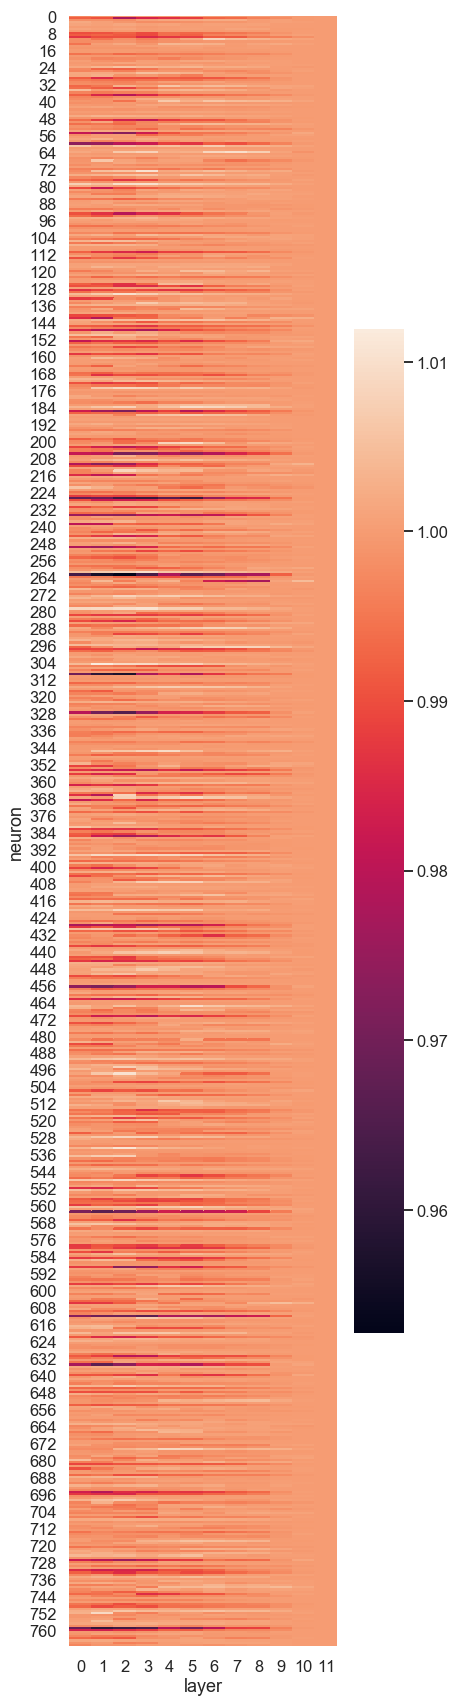

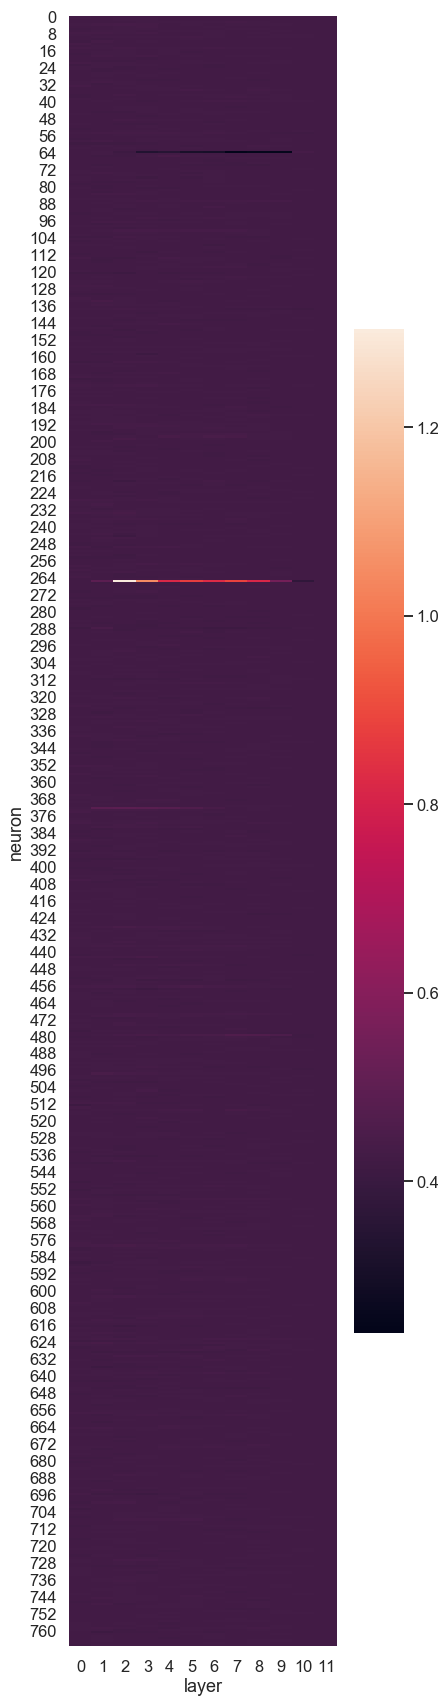

In [4]:
for p, name, mode in zip(paths, fnames, modes):
    results_df = pd.read_csv(p)
    analyze_effect_results(
        results_df, 
        mode, 
        'all', 
        'woman',
        savefig=folder_name + name + "_all_alpha1.pdf")

## Analysis of effects

- Check absolute effect abs(odds-1), color by effect direction
- Analyze the most active neurons overall
- Scatter max activation vs. profession score
- Be able to filter by direction

In [5]:
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

In [124]:
file_name = 'results/20191003_neuron_intervention/man_minus_woman.csv'
direction = "man"

df = pd.read_csv(file_name)
# calculate odds
if direction == "woman":
    odds_base = df['candidate2_base_prob'] / df['candidate1_base_prob']
    odds_intervention = df['candidate2_prob'] / df['candidate1_prob']
    odds_ratio = odds_intervention / odds_base
elif direction == "man":
    odds_base = df['candidate1_base_prob'] / df['candidate2_base_prob']
    odds_intervention = df['candidate1_prob'] / df['candidate2_prob']
    odds_ratio = odds_intervention / odds_base
else:
    raise ValueError("use valid direction")
df['odds_ratio'] = odds_ratio
df['odds_diff'] = df['odds_ratio'].apply(lambda x: x-1)
df['odds_abs'] = df['odds_diff'].apply(lambda x: abs(x))

In [125]:
def get_quant(series):
    return series.quantile(0.95)

def get_98_quant(series):
    return series.quantile(0.999)

def odds_direction(x):
    orig_max = max(x.min(), x.max(), key=abs)
    return 'Positive' if orig_max > 0 else 'Negative'

In [126]:
quantiles = df.groupby('base_string').agg(
    {'odds_abs':  ['max', get_quant],
     'odds_diff': ['mean', get_quant, get_98_quant, odds_direction, 'max', 'min'] })
quantiles.columns = ['_'.join(col).strip() for col in quantiles.columns.values]
quantiles = quantiles.reset_index().sort_values('odds_abs_max')
quantiles.head(2)

,base_string,odds_abs_max,odds_abs_get_quant,odds_diff_mean,odds_diff_get_quant,odds_diff_get_98_quant,odds_diff_odds_direction,odds_diff_max,odds_diff_min
14,The attorney said that,0.028505,0.005263,0.000715,0.004975,0.021030,Positive,0.028505,-0.011145
57,The detective said that,0.033098,0.007365,0.000984,0.007053,0.026887,Positive,0.033098,-0.013406


In [127]:
fig = px.bar(quantiles, 
             x='base_string', 
             y='odds_abs_max',
             color='odds_diff_odds_direction',
             hover_name="base_string",
             hover_data=["odds_abs_get_quant","odds_diff_max","odds_diff_min"]
             )
fig.update_layout(
    width=1000,
    title_text= "Maximum Odds per Example"
    )
fig.write_image(file_name[:-4] + "_Odds_per_example.pdf")
fig.show()


## Effect Correlated with Profession Score

In [128]:
profession_stereotypicality = {}
with open("professions_neutral.json") as f:
    for l in f:
        for p in eval(l):
            profession_stereotypicality[p[0]] = {
                'stereotypicality': p[2],
                'definitional': p[1]}
# Either use odds_diff_get_quant, odds_diff_get_98_quant, or odds_diff_mean, odds_diff_max
for k, v in quantiles.iterrows():
    profession_stereotypicality[v['base_string'].split()[1]]['odds'] = v['odds_diff_max']

In [129]:
profession_df = pd.DataFrame(profession_stereotypicality).T
profession_df = profession_df.dropna()
profession_df.head(5)

,definitional,odds,stereotypicality
accountant,0.0,0.052607,0.4
acquaintance,0.0,0.043945,0.0
administrator,0.0,0.064243,0.2
adventurer,0.0,0.058049,0.5
advocate,0.0,0.057541,-0.1


In [130]:
profession_df['total_bias'] = profession_df['stereotypicality'] + profession_df['definitional']
profession_df['max_bias'] = profession_df[["stereotypicality", "definitional"]].max(axis=1)

In [131]:
fig = px.scatter(
    profession_df, 
    x="definitional", 
    y="odds", 
#     color="species",
    trendline="ols")
fig.write_image(file_name[:-4] + "_Definitionalility_vs_odds.pdf")

fig.show()

/Users/Sebastian/anaconda2/envs/pytorch4/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



In [132]:
fig = px.scatter(
    profession_df[profession_df['stereotypicality'] > 0], 
    x="stereotypicality", 
    y="odds", 
#     color="species",
    trendline="ols")
fig.write_image(file_name[:-4] + "_Stereotypicality_vs_odds.pdf")

fig.show()

In [133]:
fig = px.scatter(
    profession_df[profession_df['total_bias'] > 0], 
    x="total_bias", 
    y="odds", 
#     color="species",
    trendline="ols")
fig.write_image(file_name[:-4] + "_total_bias_vs_odds.pdf")

fig.show()

### Most Active Neurons Overall

In [134]:
neuron_df = df.groupby(['layer', 'neuron']).agg(
    {'odds_abs':  ['mean', 'max', get_quant],
     'odds_diff': ['mean', odds_direction, 'max', 'min'] })
neuron_df.columns = ['_'.join(col).strip() for col in neuron_df.columns.values]
neuron_df.reset_index(inplace=True)
neuron_df['layer_jitter'] = neuron_df['layer'].apply(
    lambda x: x+np.random.normal(0,0.05))
neuron_df.head()

,layer,neuron,odds_abs_mean,odds_abs_max,odds_abs_get_quant,odds_diff_mean,odds_diff_odds_direction,odds_diff_max,odds_diff_min,layer_jitter
0,0,0,0.003522,0.012066,0.008834,0.002802,Positive,0.012066,-0.006578,0.084982
1,0,1,0.008458,0.041892,0.021453,0.007967,Positive,0.041892,-0.009665,-0.024102
2,0,2,0.003123,0.014474,0.007565,0.001842,Negative,0.011201,-0.014474,0.061470
3,0,3,0.002383,0.011620,0.005228,-0.001911,Negative,0.007843,-0.011620,0.024585
4,0,4,0.001414,0.005478,0.003559,-0.001130,Negative,0.005109,-0.005478,-0.034527


In [135]:
# Compute avg odds per direction
neuron_direction_dict = {}
for k, v in neuron_df.iterrows():
    neuron_direction_dict[(v['layer'], v['neuron'])] = v['odds_diff_odds_direction']

def get_neuron_value(dfrow):
    return neuron_direction_dict[(dfrow['layer'], dfrow['neuron'])]

df['direction'] = df.apply(get_neuron_value, axis=1)

In [136]:
# Group effect by layer and separate direction
layer_effect = df.groupby(['layer', 'direction']).agg({'odds_diff': 'mean'}).reset_index()
layer_effect.head(2)

,layer,direction,odds_diff
0,0,Negative,-0.001201
1,0,Positive,0.004375


In [137]:
fig = px.scatter(neuron_df, 
                 x='layer_jitter', 
                 y='odds_diff_mean',
                 color='odds_diff_odds_direction',
                 opacity=0.3,
                 hover_data=['neuron', "odds_abs_get_quant","odds_diff_max","odds_diff_min"]
                 )
fig.add_trace(go.Scatter(
    x=layer_effect[layer_effect['direction'] == 'Positive']['layer'],
    y=layer_effect[layer_effect['direction'] == 'Positive']['odds_diff'],
    mode='lines',
    line_width=4))
fig.add_trace(go.Scatter(
    x=layer_effect[layer_effect['direction'] == 'Negative']['layer'],
    y=layer_effect[layer_effect['direction'] == 'Negative']['odds_diff'],
    mode='lines',
    line_width=4))
fig.update_layout(
    width=1000,
    title_text= "Odds per Neuron"
    )
fig.write_image(file_name[:-4] + "_Odds_per_neuron.pdf")


fig.show()


## Filter to Male / Female

In [123]:
with open("professions_male.json") as f:
    for l in f:
        male_list = ["The {} said that".format(i[0]) for i in eval(l)]   
with open("professions_female.json") as f:
    for l in f:
        female_list = ["The {} said that".format(i[0]) for i in eval(l)]   

In [52]:
def filter_to(df, wordlist):
    return df[df['base_string'].isin(wordlist)]